# COURSE: A deep understanding of deep learning
## SECTION: FFN milestone projects
### LECTURE: Project 3: FFN for missing data interpolation
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202212

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

# for number-crunching
import numpy as np

import copy

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import seaborn as sns

/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_57581/3484173197.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Import and process the data

In [2]:
# import the data
url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')

# z-score all columns
data = (data - data.mean())/data.std(ddof=1)

# save a copy of the data (because we'll replace some values with nan's below)
dataOrig = copy.deepcopy( data )

# Replace some elements with NaN

In [3]:
# number of data points to set missing
n2nan = 10

# pick n random rows to set to nan 
# (note: in the video I don't have replace=False, which means it's possible to select the same values twice)
whichVals2nan = np.random.choice(range(len(data)),size=n2nan,replace=False)

# set those values to be nan (safe to ignore the overwrite warning)
data['residual sugar'][whichVals2nan] = np.nan

# for splitting the data, it will be helpful to have a vector of all real-valued rows
whichValsNotNan = np.where(~data['residual sugar'].isna())[0]

# confirm
print(np.sort(whichVals2nan))
print(np.where(data['residual sugar'].isna())[0])

[ 187  298  446  531  556  670  803 1179 1351 1531]
[ 187  298  446  531  556  670  803 1179 1351 1531]


# Re-organize the data: train/test in DataLoaders

In [4]:
# convert from pandas dataframe to tensor

# vector with residual sugar dropped, for training data
cols2keep = data.keys()
cols2keep = cols2keep.drop('residual sugar')

# extract dataframe to TRAIN tensors
train_dataT  = torch.tensor( data[cols2keep].values ).float()
train_dataT  = train_dataT[whichValsNotNan,:]
train_labelT = torch.tensor( data['residual sugar'].values ).float()
train_labelT = train_labelT[whichValsNotNan,None] # the 'None' is transform to matrix


# same for TEST tensors
test_dataT  = torch.tensor( dataOrig[cols2keep].values ).float()
test_dataT  = test_dataT[whichVals2nan,:]
test_labelT = torch.tensor( dataOrig['residual sugar'].values ).float()
test_labelT = test_labelT[whichVals2nan,None] # the 'None' is transform to matrix

# confirm sizes
print(f'Original data: {data.shape}\n')
print(f'   Train data: {train_dataT.shape}\n')
print(f' Train labels: {train_labelT.shape}\n')
print(f'    Test data: {test_dataT.shape}\n')
print(f'  Test labels: {test_labelT.shape}')

Original data: (1599, 12)

   Train data: torch.Size([1589, 11])

 Train labels: torch.Size([1589, 1])

    Test data: torch.Size([10, 11])

  Test labels: torch.Size([10, 1])


In [5]:
# then convert them into PyTorch Dataset
train_dataDataset = TensorDataset(train_dataT,train_labelT)

# finally, translate into dataloader objects
batchsize  = 32
train_data = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)

# note: we don't need a TEST dataloader; we'll just pass along the test tensor after training

# Now for the DL part

In [6]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x) 

# Train the model

In [7]:
# a function that trains the model

# global parameter
numepochs = 400

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.01)

  # initialize losses
  trainLoss = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    for X,y in train_data:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
  
  # function output
  return trainLoss

In [8]:
# create a model and train it
winenet = ANNwine()
trainLoss = trainTheModel()

In [9]:
# get the predictions for the missing data
yHatTrain = winenet(train_dataT)
yHatTest  = winenet(test_dataT)

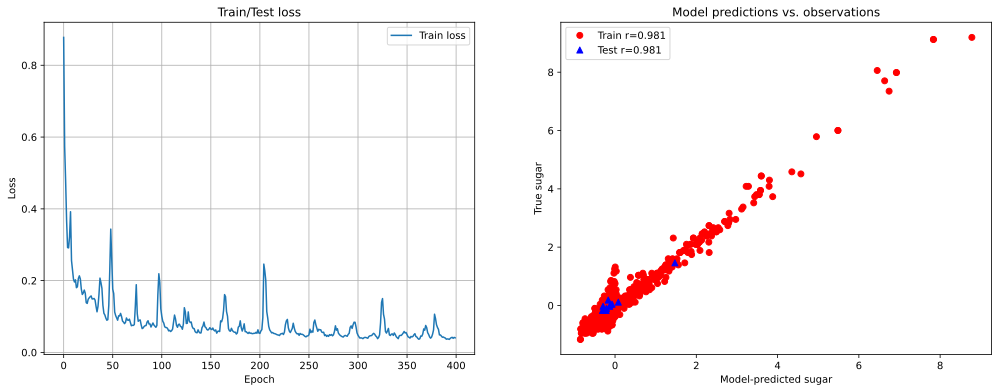

In [10]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(trainLoss,label='Train loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


ax[1].plot(yHatTrain.detach(),train_labelT,'ro')
ax[1].plot(yHatTest.detach(),test_labelT,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labelT.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labelT.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()